In [15]:
#TRUE
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

file_path = 'TRADEDATABTC1.gz'
data = pd.read_csv(file_path)

data['timestamp'] = pd.to_datetime(data['timestamp'], unit='us') + pd.Timedelta(hours=3)
data.set_index('timestamp', inplace=True)

data['price x volume'] = data['price'] * data['amount']

agg_funcs = {
    'amount': 'sum',
    'side': 'first',
    'price': ['first', 'last'],
    'price x volume': 'sum'
}

grouped = data.groupby('timestamp').agg(agg_funcs)

grouped['vwap'] = grouped[('price x volume', 'sum')] / grouped[('amount', 'sum')]

grouped['order_type'] = (grouped[('price', 'last')] != grouped[('price', 'first')]).replace({True: 'MO_1', False: 'MO_0'})

grouped.columns = [' '.join(col).strip() for col in grouped.columns.values]

grouped.rename(columns={
    'amount sum': 'total_amount',
    'side first': 'side',
    'price first': 'open_price',
    'price last': 'close_price', 
    'price x volume sum': 'total_price_x_volume'
}, inplace=True)

grouped['side'] = grouped['side'].replace({'buy': 1, 'sell': -1})

grouped = grouped[['side', 'total_amount', 'vwap', 'order_type']]

grouped


C:\Users\Александр\AppData\Local\Temp\ipykernel_6576\3435072095.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped['side'] = grouped['side'].replace({'buy': 1, 'sell': -1})


,side,total_amount,vwap,order_type
timestamp,,,,
2023-10-02 03:00:00.625,1,3570,28340.0,MO_0
2023-10-02 03:00:00.645,1,7320,28342.5,MO_0
2023-10-02 03:00:23.913,-1,1050,28337.5,MO_0
2023-10-02 03:01:16.134,1,100,28345.0,MO_0
2023-10-02 03:01:16.171,1,6620,28350.0,MO_0
...,...,...,...,...
2023-10-03 02:58:59.906,-1,800,27882.5,MO_0
2023-10-03 02:58:59.907,-1,980,27882.5,MO_0
2023-10-03 02:58:59.908,-1,1730,27882.5,MO_0


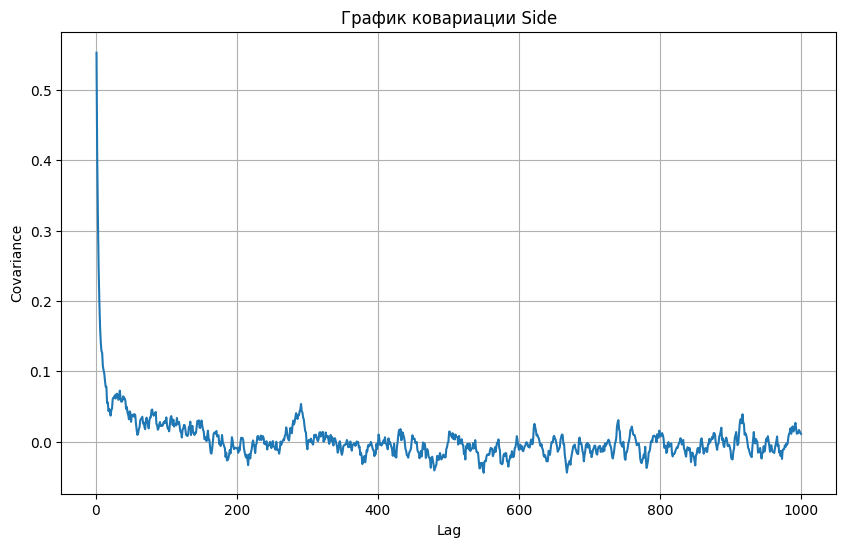

In [16]:
lags = []
covs = []

for i in range(1, 101):
    lags.append(i)
    covs.append(grouped['side'].shift(i).cov(grouped['side']))

cov_df = pd.DataFrame(covs, lags)

plt.figure(figsize=(10, 6))
plt.plot(cov_df)
plt.title('График ковариации Side')
plt.xlabel('Lag')
plt.ylabel('Covariance')
plt.grid(True)
plt.show()
